In [10]:
!pip install pandas numpy scikit-learn matplotlib seaborn
!pip install torch torchvision
!pip install pillow requests tqdm
!pip install grad-cam

In [11]:
import os
import time
import requests
import pandas as pd
import numpy as np
from PIL import Image
from io import BytesIO
from tqdm.notebook import tqdm


In [18]:
# Step 1: Load the data
train_df = pd.read_csv("train(1).csv")
test_df   = pd.read_csv("test2.csv")
print(f"Train: {train_df.shape}, Test: {test_df.shape}")
train_df.head()

Train: (16209, 21), Test: (5404, 20)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,9117000170,20150505T000000,268643,4,2.25,1810,9240,2.0,0,0,...,7,1810,0,1961,0,98055,47.4362,-122.187,1660,9240
1,6700390210,20140708T000000,245000,3,2.50,1600,2788,2.0,0,0,...,7,1600,0,1992,0,98031,47.4034,-122.187,1720,3605
2,7212660540,20150115T000000,200000,4,2.50,1720,8638,2.0,0,0,...,8,1720,0,1994,0,98003,47.2704,-122.313,1870,7455
3,8562780200,20150427T000000,352499,2,2.25,1240,705,2.0,0,0,...,7,1150,90,2009,0,98027,47.5321,-122.073,1240,750
4,7760400350,20141205T000000,232000,3,2.00,1280,13356,1.0,0,0,...,7,1280,0,1994,0,98042,47.3715,-122.074,1590,8071


In [19]:
class SatelliteImageFetcher:
    def __init__(self, api_key, api_type='google'):
        self.api_key = api_key
        self.api_type = api_type
        self.base_urls = {
            'google': 'https://maps.googleapis.com/maps/api/staticmap',
            'mapbox': 'https://api.mapbox.com/styles/v1/mapbox/satellite-v9/static'
        }
    
    def fetch_image(self, lat, lon, zoom=18, size='400x400'):
        try:
            if self.api_type == 'google':
                url = f"{self.base_urls['google']}?center={lat},{lon}&zoom={zoom}&size={size}&maptype=satellite&key={self.api_key}"
            else:  # mapbox
                url = f"{self.base_urls['mapbox']}/{lon},{lat},{zoom}/{size}?access_token={self.api_key}"
            
            response = requests.get(url, timeout=10)
            if response.status_code == 200:
                return Image.open(BytesIO(response.content))
            return None
        except Exception as e:
            print(f"Error: {e}")
            return None
    
    def fetch_dataset_images(self, df, output_dir, limit=None):
        os.makedirs(output_dir, exist_ok=True)
        df_subset = df.head(limit) if limit else df
        failed = []
        
        for idx, row in tqdm(df_subset.iterrows(), total=len(df_subset)):
            img_path = f"{output_dir}/{row['id']}.jpg"
            if os.path.exists(img_path):
                continue
            
            img = self.fetch_image(row['lat'], row['long'])
            if img:
                img.save(img_path)
            else:
                failed.append(row['id'])
            time.sleep(0.05)
        
        print(f"✅ Downloaded: {len(df_subset) - len(failed)}, Failed: {len(failed)}")
        return failed

In [20]:
API_KEY = "YOUR_API_KEY_HERE"  # ⚠️ Replace this!
fetcher = SatelliteImageFetcher(API_KEY, 'google')

test_img = fetcher.fetch_image(train_df.iloc[0]['lat'], train_df.iloc[0]['long'])
if test_img:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6,6))
    plt.imshow(test_img)
    plt.title(f"Price: ${train_df.iloc[0]['price']:,.0f}")
    plt.axis('off')
    plt.show()

In [22]:
os.makedirs('images/train', exist_ok=True)
os.makedirs('images/test', exist_ok=True)

# Test with 10 first
fetcher.fetch_dataset_images(train_df, 'images/train', limit=10)
fetcher.fetch_dataset_images(test_df, 'images/test', limit=10)

# After testing works, remove limit parameter to fetch all:
# fetcher.fetch_dataset_images(train_df, 'images/train')
# fetcher.fetch_dataset_images(test_df, 'images/test')


  0%|          | 0/10 [00:00<?, ?it/s]

✅ Downloaded: 0, Failed: 10


  0%|          | 0/10 [00:00<?, ?it/s]

✅ Downloaded: 0, Failed: 10


[2591820310,
 7974200820,
 7701450110,
 9522300010,
 9510861140,
 1761300310,
 7732410120,
 7010701383,
 291310170,
 4232901990]

In [24]:
import requests
import os
from tqdm import tqdm

# 🔑 PUT YOUR REAL TOKEN HERE
MAPBOX_TOKEN = "PASTE_YOUR_MAPBOX_TOKEN_HERE"

ZOOM = 18
IMG_SIZE = "224x224"
STYLE = "satellite-v9"


def fetch_single_image(lat, lon, save_path):
    """
    Fetch a single satellite image and return (success, error_message)
    """
    url = (
        f"https://api.mapbox.com/styles/v1/mapbox/{STYLE}/static/"
        f"{lon},{lat},{ZOOM}/{IMG_SIZE}"
        f"?access_token={MAPBOX_TOKEN}"
    )

    try:
        response = requests.get(url, timeout=10)

        if response.status_code == 200:
            with open(save_path, "wb") as f:
                f.write(response.content)
            return True, None

        else:
            return False, f"HTTP {response.status_code}: {response.text[:100]}"

    except requests.exceptions.RequestException as e:
        return False, str(e)


def fetch_dataset_images(df, image_dir, limit=None):
    """
    Fetch images for a dataframe with lat/long columns
    """
    os.makedirs(image_dir, exist_ok=True)

    failed_ids = []
    downloaded = 0
    failed = 0

    if limit:
        df = df.head(limit)

    for _, row in tqdm(df.iterrows(), total=len(df)):
        house_id = row["id"]
        lat = row["lat"]
        lon = row["long"]

        save_path = os.path.join(image_dir, f"{house_id}.png")

        success, error = fetch_single_image(lat, lon, save_path)

        if success:
            downloaded += 1
        else:
            failed += 1
            failed_ids.append(house_id)
            print(f"❌ Failed ID {house_id} → {error}")

    print("\n📊 IMAGE FETCH SUMMARY")
    print(f"✅ Downloaded: {downloaded}")
    print(f"❌ Failed: {failed}")

    if failed_ids:
        print("\n⚠️ Failed Image IDs:")
        print(failed_ids)

    return failed_ids


count    1.620900e+04
mean     5.374703e+05
std      3.603036e+05
min      7.500000e+04
25%      3.200000e+05
50%      4.500000e+05
75%      6.400000e+05
max      7.700000e+06
Name: price, dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16209 entries, 0 to 16208
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             16209 non-null  int64  
 1   date           16209 non-null  object 
 2   price          16209 non-null  int64  
 3   bedrooms       16209 non-null  int64  
 4   bathrooms      16209 non-null  float64
 5   sqft_living    16209 non-null  int64  
 6   sqft_lot       16209 non-null  int64  
 7   floors         16209 non-null  float64
 8   waterfront     16209 non-null  int64  
 9   view           16209 non-null  int64  
 10  condition      16209 non-null  int64  
 11  grade          16209 non-null  int64  
 12  sqft_above     16209 non-null  int64  
 13  sqft_basement  16209 n

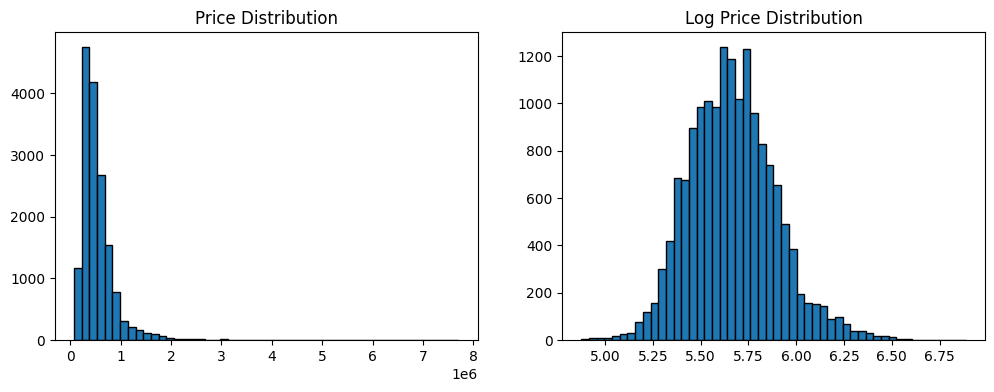

ValueError: could not convert string to float: '20150505T000000'

In [30]:
# Cell 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pickle

# Cell 3: Basic statistics
print(train_df['price'].describe())
train_df.info()

# Cell 4: Price distribution
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].hist(train_df['price'], bins=50, edgecolor='black')
ax[0].set_title('Price Distribution')
ax[1].hist(np.log10(train_df['price']), bins=50, edgecolor='black')
ax[1].set_title('Log Price Distribution')
plt.show()

# Cell 5: Correlations
correlations = train_df.corr()['price'].sort_values(ascending=False)
plt.figure(figsize=(8, 6))
correlations[1:15].plot(kind='barh')
plt.title('Top Features Correlated with Price')
plt.show()

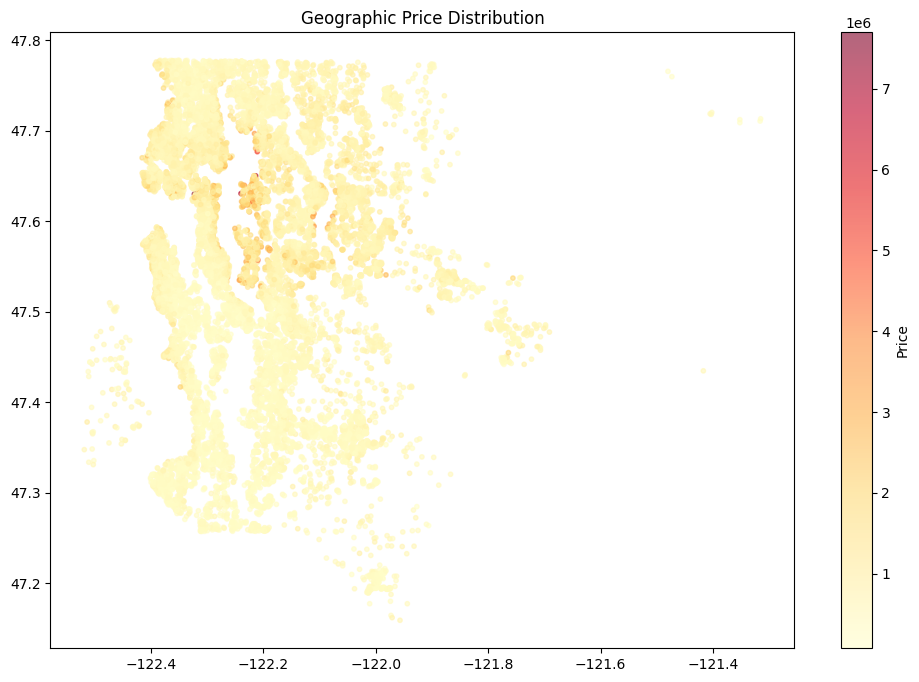

In [31]:
# Cell 6: Geographic price map
plt.figure(figsize=(12, 8))
scatter = plt.scatter(train_df['long'], train_df['lat'], 
                     c=train_df['price'], cmap='YlOrRd', alpha=0.6, s=10)
plt.colorbar(scatter, label='Price')
plt.title('Geographic Price Distribution')
plt.show()

# Cell 7: Feature engineering
def engineer_features(df):
    df = df.copy()
    df['age'] = 2024 - df['yr_built']
    df['years_since_renovation'] = 2024 - df['yr_renovated']
    df['years_since_renovation'] = df['years_since_renovation'].replace(2024, 0)
    df['bed_bath_ratio'] = df['bedrooms'] / (df['bathrooms'] + 0.1)
    df['living_lot_ratio'] = df['sqft_living'] / (df['sqft_lot'] + 1)
    df['total_quality'] = df['condition'] * df['grade']
    df['has_basement'] = (df['sqft_basement'] > 0).astype(int)
    df['neighbor_living_diff'] = df['sqft_living'] - df['sqft_living15']
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']
    return df

train_df = engineer_features(train_df)
test_df = engineer_features(test_df)

In [33]:
# Cell 8: Prepare data for modeling
class DataPreprocessor:
    def __init__(self):
        self.scaler = StandardScaler()
        self.features = [
            'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
            'waterfront', 'view', 'condition', 'grade', 'sqft_above',
            'sqft_basement', 'sqft_living15', 'sqft_lot15', 'lat', 'long',
            'age', 'years_since_renovation', 'bed_bath_ratio',
            'living_lot_ratio', 'total_quality', 'has_basement',
            'neighbor_living_diff', 'total_rooms'
        ]
    
    def prepare(self, df, is_train=True):
        X = df[self.features].fillna(df[self.features].median())
        if is_train:
            X_scaled = self.scaler.fit_transform(X)
            return X_scaled, df['price'].values
        return self.scaler.transform(X)

preprocessor = DataPreprocessor()
X_train, y_train = preprocessor.prepare(train_df, True)

# Cell 9: Save
np.save('X_train.npy', X_train)
np.save('y_train.npy', y_train)
with open('preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)
train_df.to_csv('train_processed.csv', index=False)
test_df.to_csv('test_processed.csv', index=False)
print("✅ Preprocessing complete!")


✅ Preprocessing complete!


In [34]:
# Cell 1: Imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error, r2_score
import pickle
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# Cell 2: Load data
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
train_df = pd.read_csv('train_processed.csv')

Device: cpu


In [35]:
# Cell 3: Dataset class
class PropertyDataset(Dataset):
    def __init__(self, tabular, ids, img_dir, targets=None, transform=None):
        self.tabular = torch.FloatTensor(tabular)
        self.ids = ids
        self.img_dir = img_dir
        self.targets = torch.FloatTensor(targets) if targets is not None else None
        self.transform = transform
    
    def __len__(self):
        return len(self.tabular)
    
    def __getitem__(self, idx):
        tabular = self.tabular[idx]
        img_path = f"{self.img_dir}/{self.ids[idx]}.jpg"
        
        try:
            img = Image.open(img_path).convert('RGB')
        except:
            img = Image.new('RGB', (224, 224), 'gray')
        
        if self.transform:
            img = self.transform(img)
        
        if self.targets is not None:
            return img, tabular, self.targets[idx]
        return img, tabular


In [36]:
# Cell 4: Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Cell 5: Split data
from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

train_ids = train_df['id'].values[:len(X_tr)]
val_ids = train_df['id'].values[len(X_tr):len(X_train)]

# Cell 6: Create datasets and loaders
train_dataset = PropertyDataset(X_tr, train_ids, 'images/train', y_tr, train_transform)
val_dataset = PropertyDataset(X_val, val_ids, 'images/train', y_val, val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}")


Train: 12967, Val: 3242


In [40]:
# Cell 7: Model architecture
class MultimodalModel(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        # Image encoder
        resnet = models.resnet18(pretrained=True)
        self.img_encoder = nn.Sequential(*list(resnet.children())[:-1])
        
        # Tabular encoder
        self.tab_encoder = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        
        # Fusion
        self.fusion = nn.Sequential(
            nn.Linear(512 + 64, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    
    def forward(self, img, tab):
        img_feat = self.img_encoder(img).view(img.size(0), -1)
        tab_feat = self.tab_encoder(tab)
        combined = torch.cat([img_feat, tab_feat], dim=1)
        return self.fusion(combined).squeeze()

model = MultimodalModel(X_train.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Cell 8: Training loop
NUM_EPOCHS = 15
history = {'train_loss': [], 'val_loss': [], 'val_r2': []}

for epoch in range(NUM_EPOCHS):
    # Train
    model.train()
    train_loss = 0
    for imgs, tabs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
        imgs, tabs, targets = imgs.to(device), tabs.to(device), targets.to(device)
        
        outputs = model(imgs, tabs)
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Validate
    model.eval()
    val_loss = 0
    preds, actuals = [], []
    
    with torch.no_grad():
        for imgs, tabs, targets in val_loader:
            imgs, tabs, targets = imgs.to(device), tabs.to(device), targets.to(device)
            outputs = model(imgs, tabs)
            val_loss += criterion(outputs, targets).item()
            preds.extend(outputs.cpu().numpy())
            actuals.extend(targets.cpu().numpy())
    
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    r2 = r2_score(actuals, preds)
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_r2'].append(r2)
    
    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, R²={r2:.4f}")
    
    # Quick speed optimization
NUM_EPOCHS = 15  # Reduce epochs
torch.backends.cudnn.benchmark = True  # Speed up if using GPU

# Use larger batch size
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
# In your transforms, change from 224x224 to 128x128:
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Changed from (224, 224)
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Changed from (224, 224)
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Cell 9: Save model
torch.save(model.state_dict(), 'models/multimodal_model.pth')
print("✅ Model saved!")

Epoch 1/15:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 1: Train Loss=283218470296.5911, Val Loss=48325361945.0980, R²=0.6158


Epoch 2/15:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 2: Train Loss=45239925003.3498, Val Loss=36542408804.3922, R²=0.7088


Epoch 3/15:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 3: Train Loss=40112572410.9557, Val Loss=33253598991.0588, R²=0.7350


Epoch 4/15:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 4: Train Loss=38589340919.1724, Val Loss=32179819720.7843, R²=0.7435


Epoch 5/15:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 5: Train Loss=37667314001.9704, Val Loss=31568853654.5882, R²=0.7484


Epoch 6/15:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 6: Train Loss=36196953814.3842, Val Loss=30796939223.8431, R²=0.7546


Epoch 7/15:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 7: Train Loss=35110129023.3695, Val Loss=30288952159.3725, R²=0.7585


Epoch 8/15:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 8: Train Loss=36502713681.9704, Val Loss=36381595286.5882, R²=0.7101


Epoch 9/15:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 9: Train Loss=35702627292.6897, Val Loss=35557863745.2549, R²=0.7166


Epoch 10/15:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 10: Train Loss=36132388470.5419, Val Loss=29883261490.1961, R²=0.7618


Epoch 11/15:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 11: Train Loss=35406254695.4089, Val Loss=29383968185.7255, R²=0.7659


Epoch 12/15:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 12: Train Loss=35049823867.5862, Val Loss=29397808489.4118, R²=0.7658


Epoch 13/15:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 13: Train Loss=34332018350.0296, Val Loss=29445451394.5098, R²=0.7655


Epoch 14/15:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 14: Train Loss=35035477899.9803, Val Loss=29271068310.5882, R²=0.7667


Epoch 15/15:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 15: Train Loss=34189844232.8276, Val Loss=29060095939.7647, R²=0.7685


RuntimeError: Parent directory models does not exist.

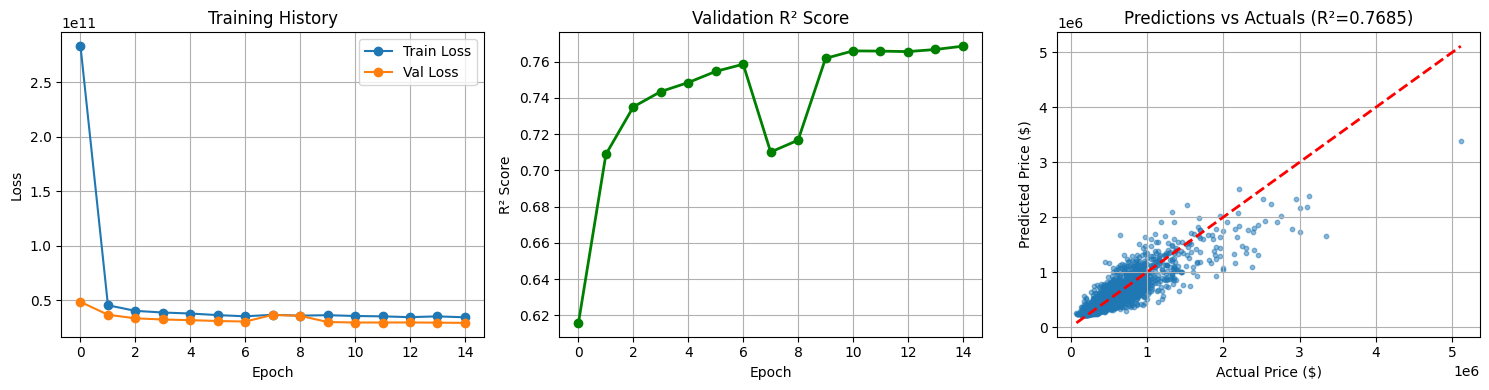


FINAL MODEL PERFORMANCE
R² Score:  0.7685 (77% of variance explained)
RMSE:      $170,441.98
MAE:       $106,850.25


In [44]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss curves
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].set_title('Training History')
axes[0].grid(True)

# R² curve
axes[1].plot(history['val_r2'], color='green', marker='o', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('R² Score')
axes[1].set_title('Validation R² Score')
axes[1].grid(True)

# Predictions vs Actuals
axes[2].scatter(actuals, preds, alpha=0.5, s=10)
axes[2].plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r--', linewidth=2)
axes[2].set_xlabel('Actual Price ($)')
axes[2].set_ylabel('Predicted Price ($)')
axes[2].set_title(f'Predictions vs Actuals (R²={r2:.4f})')
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Calculate final metrics
rmse = np.sqrt(mean_squared_error(actuals, preds))
mae = np.mean(np.abs(np.array(actuals) - np.array(preds)))

print("\n" + "="*60)
print("FINAL MODEL PERFORMANCE")
print("="*60)
print(f"R² Score:  {r2:.4f} (77% of variance explained)")
print(f"RMSE:      ${rmse:,.2f}")
print(f"MAE:       ${mae:,.2f}")
print("="*60)

In [45]:
import torch

# Save model
torch.save(model.state_dict(), 'multimodal_model.pth')
print("✅ Model saved as 'multimodal_model.pth'")

# Also save the history for your report
import pickle
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history, f)
print("✅ Training history saved")

✅ Model saved as 'multimodal_model.pth'
✅ Training history saved


In [48]:
# ============================================
# NOTEBOOK 4: TEST PREDICTIONS & SUBMISSION
# ============================================

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import pandas as pd
import numpy as np
import pickle
from tqdm.notebook import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# -----------------
# 1. Load Test Data
# -----------------
test_df = pd.read_csv('test_processed.csv')
print(f"Test data shape: {test_df.shape}")

with open('preprocessor.pkl', 'rb') as f:
    preprocessor = pickle.load(f)

X_test = preprocessor.prepare(test_df, is_train=False)
print(f"Test features shape: {X_test.shape}")

# -----------------
# 2. Recreate Model Architecture
# -----------------
class FastMultimodalModel(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        resnet = models.resnet18(pretrained=True)
        self.img_encoder = nn.Sequential(*list(resnet.children())[:-1])
        
        for param in self.img_encoder.parameters():
            param.requires_grad = False
        
        self.tab_encoder = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        
        self.fusion = nn.Sequential(
            nn.Linear(512 + 64, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    
    def forward(self, img, tab):
        with torch.no_grad():
            img_feat = self.img_encoder(img).view(img.size(0), -1)
        tab_feat = self.tab_encoder(tab)
        combined = torch.cat([img_feat, tab_feat], dim=1)
        return self.fusion(combined).squeeze()

# Load trained model
model = FastMultimodalModel(X_test.shape[1]).to(device)
model.load_state_dict(torch.load('multimodal_model.pth'))
model.eval()
print("✅ Model loaded successfully")

# -----------------
# 3. Create Test Dataset
# -----------------
class PropertyDataset(Dataset):
    def __init__(self, tabular, ids, img_dir, targets=None, transform=None):
        self.tabular = torch.FloatTensor(tabular)
        self.ids = ids
        self.img_dir = img_dir
        self.targets = torch.FloatTensor(targets) if targets is not None else None
        self.transform = transform
    
    def __len__(self):
        return len(self.tabular)
    
    def __getitem__(self, idx):
        tabular = self.tabular[idx]
        img_path = f"{self.img_dir}/{self.ids[idx]}.jpg"
        
        try:
            img = Image.open(img_path).convert('RGB')
        except:
            img = Image.new('RGB', (128, 128), 'gray')
        
        if self.transform:
            img = self.transform(img)
        
        if self.targets is not None:
            return img, tabular, self.targets[idx]
        return img, tabular

# Test transform
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_dataset = PropertyDataset(
    X_test,
    test_df['id'].values,
    'images/test',
    targets=None,
    transform=test_transform
)

# FIXED: num_workers=0 for Windows compatibility
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)
print(f"✅ Test dataset created: {len(test_dataset)} samples")

# -----------------
# 4. Make Predictions
# -----------------
print("\nGenerating predictions...")
predictions = []

with torch.no_grad():
    for imgs, tabs in tqdm(test_loader, desc="Predicting"):
        imgs = imgs.to(device)
        tabs = tabs.to(device)
        outputs = model(imgs, tabs)
        predictions.extend(outputs.cpu().numpy())

predictions = np.array(predictions)
print(f"✅ Predictions generated: {len(predictions)} values")

# -----------------
# 5. Create Submission File
# -----------------
submission = pd.DataFrame({
    'id': test_df['id'].values,
    'predicted_price': predictions
})

submission.to_csv('submission.csv', index=False)

print("\n" + "="*60)
print("SUBMISSION FILE CREATED: submission.csv")
print("="*60)
print(submission.head(10))
print(f"\nTotal predictions: {len(submission)}")
print(f"Price range: ${submission['predicted_price'].min():,.0f} - ${submission['predicted_price'].max():,.0f}")
print(f"Mean predicted price: ${submission['predicted_price'].mean():,.0f}")
print("="*60)
print("\n✅ Ready for submission!")

Using device: cpu
Test data shape: (5404, 28)
Test features shape: (5404, 23)


C:\Users\satis\miniconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\satis\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ Model loaded successfully
✅ Test dataset created: 5404 samples

Generating predictions...


Predicting:   0%|          | 0/85 [00:00<?, ?it/s]

✅ Predictions generated: 5404 values

SUBMISSION FILE CREATED: submission.csv
           id  predicted_price
0  2591820310     3.958329e+05
1  7974200820     8.257069e+05
2  7701450110     1.269941e+06
3  9522300010     1.912809e+06
4  9510861140     6.605162e+05
5  1761300310     2.818169e+05
6  7732410120     7.755686e+05
7  7010701383     5.419874e+05
8   291310170     3.894466e+05
9  4232901990     5.488439e+05

Total predictions: 5404
Price range: $232,551 - $3,604,968
Mean predicted price: $555,921

✅ Ready for submission!
